In [46]:
import os
import os.path as osp
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle as pkl

In [68]:
# Load a video into a numpy array
def load_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        if len(frames) == 100:
            break
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return np.array(frames)

# Write a numpy array to a video file
def write_video(video, video_path, fps=30):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(video_path, fourcc, fps, (video.shape[2], video.shape[1]))
    for frame in video:
        out.write(frame)
    out.release()

# Load a source image into a numpy array
def load_source_image(image_path):
    image = cv2.imread(image_path)
    return image

# Resize the short side of the video to 512 pixels, and do center crop for the long side, the output size is 512x512
def center_crop_and_resize_video(video, rt=512):
    """
    Args:
        video: numpy array, shape (T, H, W, C)
        rt: int, the short side of the output video (resize to)
    Returns:
        cropped_video: numpy array, shape (T, 512, 512, C)
    """
    frame_num, height, width, _ = video.shape
    if height > width:
        new_width = rt
        new_height = int(height * rt / width)
    else:
        new_height = rt
        new_width = int(width * rt / height)
    # Resize the video
    resized_video = np.stack([cv2.resize(img, (new_width, new_height)) for img in video])
    # Crop the center of the video
    _, height, width, _ = resized_video.shape
    start_x = (width - rt) // 2
    start_y = (height - rt) // 2
    print(height, width, start_x, start_y)
    cropped_video = resized_video[:,start_y:start_y+rt, start_x:start_x+rt]
    return cropped_video



In [70]:
driving_video_root = '/prj/qct/mmrd-cv/esper/Misc0002/dataset/liveportrait-augmentation/driving_videos'
# concat_video_root = '/prj/qct/mmrd-cv/esper/Misc0002/dataset/liveportrait-augmentation/augmented_videos/keli-driving'
concat_video_root = '/prj/qct/mmrd-cv/esper/Misc0002/dataset/liveportrait-augmentation/augmented_videos'
out_root = '/prj/qct/mmrd-cv/esper/Misc0002/dataset/liveportrait-augmentation/verify_videos'

driving_video_paths = glob.glob(os.path.join(driving_video_root, '*.mp4'))
drivers = [osp.splitext(osp.split(p)[1])[0] for p in driving_video_paths]
driver_to_path = {dn: path for dn, path in zip(drivers, driving_video_paths)}

source_names = ['ardavanm', 'duc']
print(drivers)

['subject25_cap', 'subject25_tied_hair', 'subject5_cap', 'subject5_tied_hair', 'ning_1', 'ning_2', 'ning_3', 'ning_4', 'ning_5', 'atalie', 'keli', 'matt']


In [56]:
video = load_video(driving_video_paths[10])
concat_video = load_video(osp.join(concat_video_root, f'{drivers[0]}-driving',f'{source_names[0]}--{drivers[0]}_concat.mp4'))
print(video.shape, concat_video.shape)

(100, 2048, 2448, 3) (100, 512, 1024, 3)


In [60]:
cropped_video = center_crop_and_resize_video(video)
combination = np.concatenate([cropped_video, concat_video], axis=2)
print(cropped_video.shape, combination.shape)


512 612 50 0
(100, 512, 512, 3) (100, 512, 1536, 3)


In [71]:
for dn in drivers:
    driving_video = load_video(driver_to_path[dn])
    for sn in source_names:
        concat_video_path = osp.join(concat_video_root, f'{dn}-driving',f'{sn}--{dn}_concat.mp4')
        concat_video = load_video(concat_video_path)
        cropped_driving_video = center_crop_and_resize_video(driving_video)
        combination = np.concatenate([cropped_driving_video, concat_video], axis=2)
        print(cropped_driving_video.shape, combination.shape)
        out_path = osp.join(out_root, f'{dn}-driving', f'{sn}--{dn}_concat.mp4')
        os.makedirs(osp.dirname(out_path), exist_ok=True)
        write_video(combination, out_path, fps=30)
        break
    break

        

512 512 0 0
(100, 512, 512, 3) (100, 512, 1536, 3)


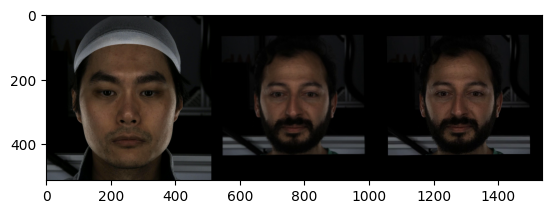

In [61]:
# Visualize the first frame of the cropped video
plt.imshow(cv2.cvtColor(combination[0], cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
cropped_video.shape

(42, 428, 512, 3)

In [ ]:
# Concate the cropped video and the source image
def concate_video_and_source_image(video, source_image):
    """
    Args:
        video: numpy array, shape (T, L, L, C)
        source_image: numpy array, shape (L, 2L, C)
    Returns:
        concated_video: numpy array, shape (T, L, L, C)
    """
    video_height, video_width, _ = video.shape
    source_image_height, source_image_width, _ = source_image.shape
    if video_height > video_width:
        source_image_height = int(source_image_height * video_width / video_height)
        source_image_width = video_width
    else:
        source_image_width = int(source_image_width * video_height / video_width)
        source_image_height = video_height
    resized_source_image = cv2.resize(source_image, (source_image_width, source_image_height))
    concated_video = np.concatenate([video, resized_source_image], axis=0)
    return concated_video